In [12]:
## Importing keras library and its modules 
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

### Data Loading

In [6]:
## Initializing the dataset path and image size
dataset_path = 'C:\\Users\\muppa\\Downloads\\challenges-in-representation-learning-facial-expression-recognition-challenge\\fer2013\\fer2013.csv'
image_size=(48,48)

In [10]:
## defining the method to load fer2013 csv dataset
## returns faces and emotions of the corresponding image
def load_fer2013():
    data = pd.read_csv(dataset_path)
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = pd.get_dummies(data['emotion']).values
    return faces, emotions

### Pre-processing

In [8]:
## changing the data types, normalizing the image
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

In [13]:
## Loading data, preprocessing and splitting train and test
faces, emotions = load_fer2013()
faces = preprocess_input(faces)
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)

### Model Building

In [15]:
# Initializing the model training parameters
batch_size = 32
num_epochs = 110
input_shape = (48, 48, 1)
verbose = 1
num_classes = 7
patience = 50
base_path = 'models/'
l2_regularization=0.01

In [16]:
# Initializing the data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [29]:
# model parameters
regularization = l2(l2_regularization)
 
# base method using functional api model
img_input = Input(input_shape)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
 
# module 1
residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 2
residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 3
residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 4
residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
x = Conv2D(num_classes, (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax',name='predictions')(x)
 
model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


# callbacks
log_file_path = 'model' + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = 'model' + '_mini_XCEPTION'
model_names = trained_models_path + '_epoch02d_val_acc_2f.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 46, 46, 8)    72          input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_70 (BatchNo (None, 46, 46, 8)    32          conv2d_35[0][0]                  
__________________________________________________________________________________________________
activation_30 (Activation)      (None, 46, 46, 8)    0           batch_normalization_70[0][0]     
____________________________________________________________________________________________

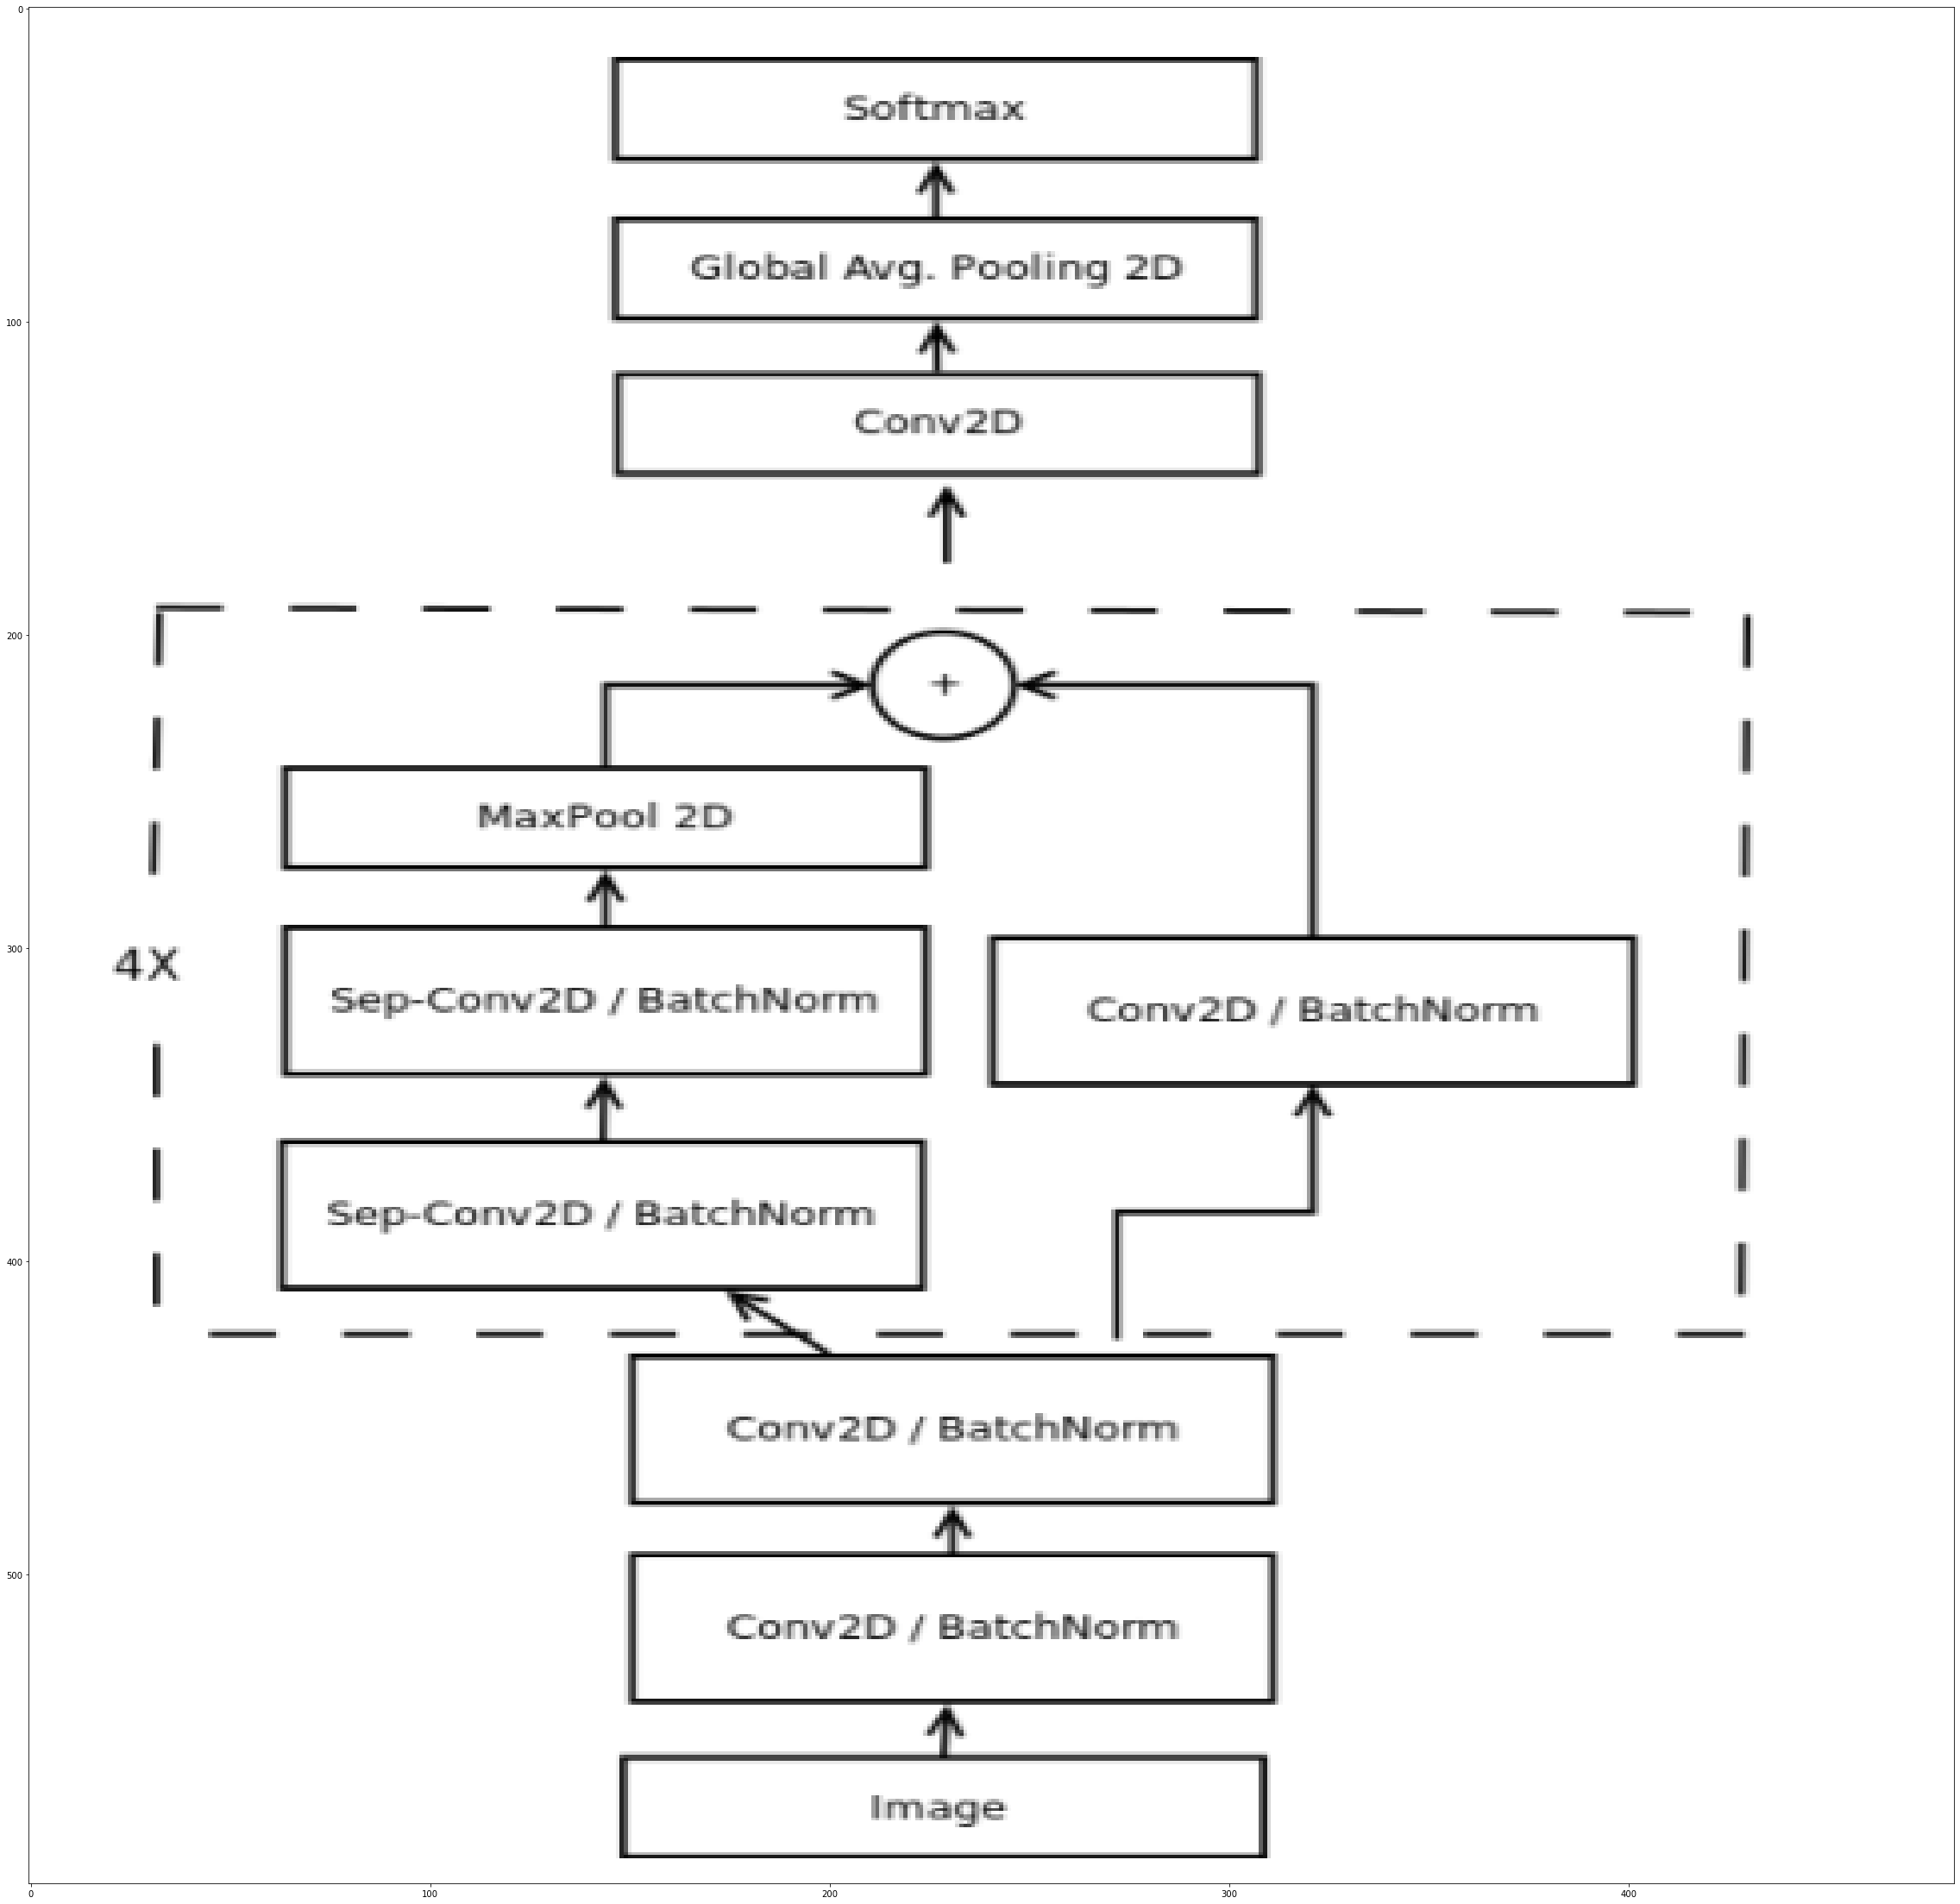

In [48]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
  
# Read Images
img = mpimg.imread('C:\\Users\\muppa\\OneDrive\\Desktop\\Hack-Roo_2021\\mini_exception_architecture.png')

fig, ax = plt.subplots(figsize=(40, 40))
# Output Images
plt.imshow(img,interpolation='nearest', aspect='auto')

In [30]:
## Training the model with the train data
model.fit_generator(data_generator.flow(xtrain, ytrain,batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))

Epoch 1/110
897/897 [==============================] - 190s 210ms/step - loss: 1.9178 - accuracy: 0.2647 - val_loss: 1.6069 - val_accuracy: 0.4074

Epoch 00001: val_loss improved from inf to 1.60688, saving model to model_mini_XCEPTION_epoch02d_val_acc_2f.hdf5
Epoch 2/110
897/897 [==============================] - 194s 216ms/step - loss: 1.5932 - accuracy: 0.4030 - val_loss: 1.4395 - val_accuracy: 0.4776

Epoch 00002: val_loss improved from 1.60688 to 1.43947, saving model to model_mini_XCEPTION_epoch02d_val_acc_2f.hdf5
Epoch 3/110
897/897 [==============================] - 193s 215ms/step - loss: 1.4405 - accuracy: 0.4631 - val_loss: 1.4069 - val_accuracy: 0.4974

Epoch 00003: val_loss improved from 1.43947 to 1.40692, saving model to model_mini_XCEPTION_epoch02d_val_acc_2f.hdf5
Epoch 4/110
897/897 [==============================] - 192s 214ms/step - loss: 1.3467 - accuracy: 0.4963 - val_loss: 1.2658 - val_accuracy: 0.5386

Epoch 00004: val_loss improved from 1.40692 to 1.26577, savin

897/897 [==============================] - 192s 215ms/step - loss: 0.9869 - accuracy: 0.6286 - val_loss: 1.0633 - val_accuracy: 0.6076

Epoch 00037: val_loss did not improve from 1.03117
Epoch 38/110
897/897 [==============================] - 193s 215ms/step - loss: 0.9785 - accuracy: 0.6328 - val_loss: 1.0392 - val_accuracy: 0.6165

Epoch 00038: val_loss did not improve from 1.03117
Epoch 39/110
897/897 [==============================] - 192s 214ms/step - loss: 0.9856 - accuracy: 0.6338 - val_loss: 1.0363 - val_accuracy: 0.6184

Epoch 00039: val_loss did not improve from 1.03117
Epoch 40/110
897/897 [==============================] - 188s 210ms/step - loss: 0.9772 - accuracy: 0.6367 - val_loss: 1.0165 - val_accuracy: 0.6266

Epoch 00040: val_loss improved from 1.03117 to 1.01651, saving model to model_mini_XCEPTION_epoch02d_val_acc_2f.hdf5
Epoch 41/110
897/897 [==============================] - 188s 210ms/step - loss: 0.9737 - accuracy: 0.6359 - val_loss: 1.0884 - val_accuracy: 0.6017

897/897 [==============================] - 187s 209ms/step - loss: 0.8414 - accuracy: 0.6849 - val_loss: 0.9563 - val_accuracy: 0.6517

Epoch 00075: val_loss improved from 0.96139 to 0.95633, saving model to model_mini_XCEPTION_epoch02d_val_acc_2f.hdf5
Epoch 76/110
897/897 [==============================] - 187s 208ms/step - loss: 0.8445 - accuracy: 0.6885 - val_loss: 0.9570 - val_accuracy: 0.6537

Epoch 00076: val_loss did not improve from 0.95633
Epoch 77/110
897/897 [==============================] - 187s 209ms/step - loss: 0.8497 - accuracy: 0.6850 - val_loss: 0.9608 - val_accuracy: 0.6488

Epoch 00077: val_loss did not improve from 0.95633
Epoch 78/110
897/897 [==============================] - 10989s 12s/step - loss: 0.8404 - accuracy: 0.6874 - val_loss: 0.9608 - val_accuracy: 0.6542

Epoch 00078: val_loss did not improve from 0.95633
Epoch 79/110
897/897 [==============================] - 6641s 7s/step - loss: 0.8418 - accuracy: 0.6858 - val_loss: 0.9586 - val_accuracy: 0.6519



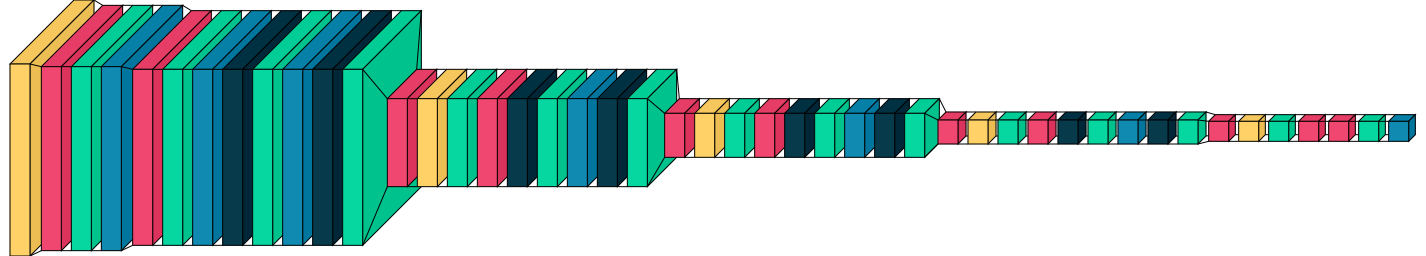

In [31]:
## Visulizing the model that is build above
import visualkeras
visualkeras.layered_view(model)

In [32]:
## Evaluating the model performance
model.evaluate(xtest,ytest)

225/225 [==============================] - 5s 23ms/step - loss: 0.9569 - accuracy: 0.6571


[0.956902027130127, 0.6571468114852905]